<a href="https://colab.research.google.com/github/ADVAIT135/CDAC/blob/main/6.%20Deep%20Learning/ASSIGNMENT%203/CDAC_PGDAI_DEEP_LEARNING_ASSIGNMENT__3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name : ADVAIT GURUNATH CHAVAN
# Email Id: advaitchavan135@gmail.com
# CDAC PGDAI DEEP LEARNING ASSIGNMENT__3

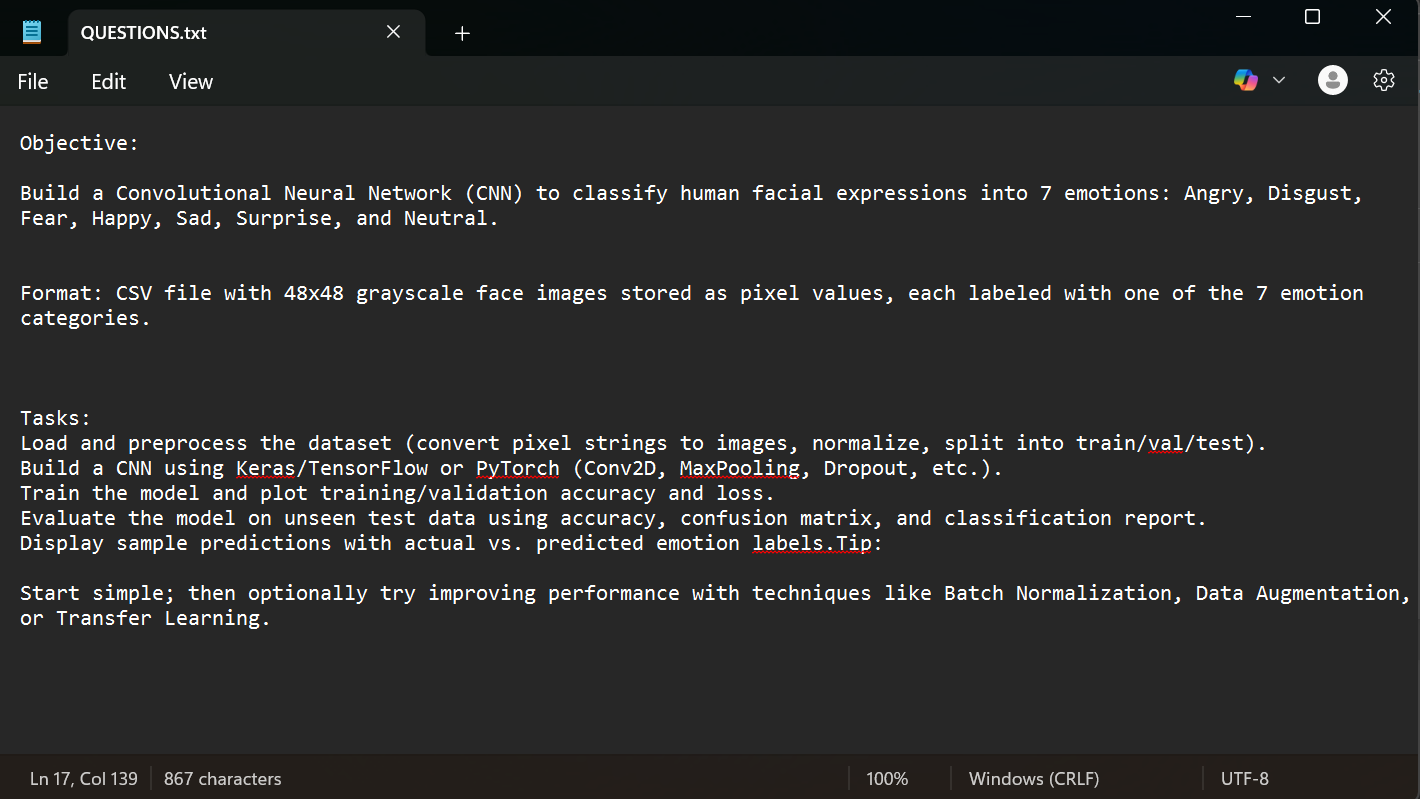

## 1. Loading dataset from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [27]:
train_dir = os.path.join('/kaggle/input/fer2013/train')
test_dir  = os.path.join('/kaggle/input/fer2013/test')

In [28]:
img_height, img_width = 96, 96
batch_size = 32

## 2. Create Data Generators

In [29]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # Reserve 15% for validation
)

In [30]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",      # Use full-color images as they are
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

Found 24406 images belonging to 7 classes.


In [31]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)

Found 4303 images belonging to 7 classes.


In [32]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",      # Do not convert to grayscale – keep full color
    batch_size=1,          # Batch size 1 for evaluation
    class_mode="categorical",
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [33]:
classes = train_generator.classes
unique_classes = np.unique(classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=classes
)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

Computed class weights: {0: np.float64(1.0266700319703854), 1: np.float64(9.397766653831344), 2: np.float64(1.0010253886222877), 3: np.float64(0.5684936293121521), 4: np.float64(0.8260060243002674), 5: np.float64(0.8491406304362953), 6: np.float64(1.2932386604493429)}


## 3. Build the Convolutional Neural Network

In [34]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")  # 7 emotion classes
])

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,487 (9.26 MB)

 Trainable params: 167,687 (655.03 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [37]:
earlystopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

## 4. Train the Model with Data Augmentation

In [38]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    class_weight=class_weights,
    callbacks=[earlystopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 345s 446ms/step - accuracy: 0.1826 - loss: 2.8804 - val_accuracy: 0.2803 - val_loss: 1.9240 - learning_rate: 1.0000e-04
Epoch 2/30
  1/762 ━━━━━━━━━━━━━━━━━━━━ 2:34 203ms/step - accuracy: 0.3125 - loss: 1.6679

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


762/762 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.3125 - loss: 1.6679 - val_accuracy: 0.2857 - val_loss: 1.9132 - learning_rate: 1.0000e-04
Epoch 3/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 260s 341ms/step - accuracy: 0.2375 - loss: 2.3706 - val_accuracy: 0.3267 - val_loss: 1.7989 - learning_rate: 1.0000e-04
Epoch 4/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.2500 - loss: 2.1617 - val_accuracy: 0.3284 - val_loss: 1.8106 - learning_rate: 1.0000e-04
Epoch 5/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 260s 341ms/step - accuracy: 0.2646 - loss: 2.1766 - val_accuracy: 0.3554 - val_loss: 1.7318 - learning_rate: 1.0000e-04
Epoch 6/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.1875 - loss: 2.9712 - val_accuracy: 0.3458 - val_loss: 1.7382 - learning_rate: 1.0000e-04
Epoch 7/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 261s 342ms/step - accuracy: 0.2807 - loss: 2.0164 - val_accuracy: 0.3540 - val_loss: 1.6917 - learning_rate: 1.0000e-04
Epoch 8/30
762/762 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - a

## 5. Visualize Training History

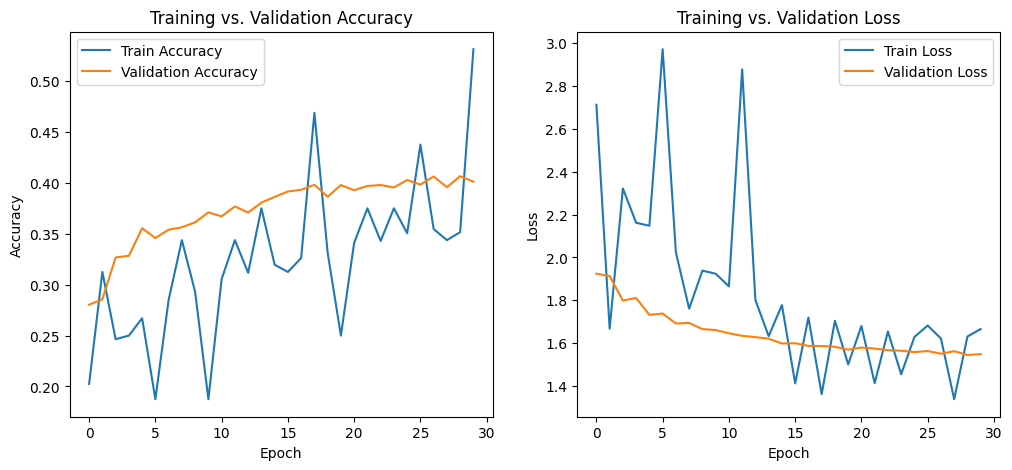

In [39]:
plt.figure(figsize=(12, 5))


# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

## 6. Evaluate on the Test Set

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.3504 - loss: 1.5904
Test Loss: 1.5581
Test Accuracy: 0.4061


In [41]:
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step


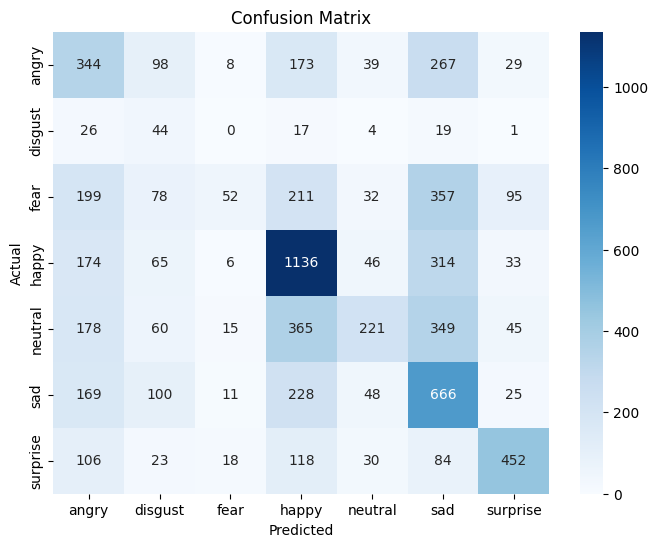

In [42]:
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [43]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       angry       0.29      0.36      0.32       958
     disgust       0.09      0.40      0.15       111
        fear       0.47      0.05      0.09      1024
       happy       0.51      0.64      0.56      1774
     neutral       0.53      0.18      0.27      1233
         sad       0.32      0.53      0.40      1247
    surprise       0.66      0.54      0.60       831

    accuracy                           0.41      7178
   macro avg       0.41      0.39      0.34      7178
weighted avg       0.46      0.41      0.38      7178



## 7. Display Sample Predictions

In [44]:
import numpy as np
import random

In [45]:
def deprocess_image(img):
    img = (img + 1.0) / 2.0  # Convert from [-1, 1] to [0, 1]
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


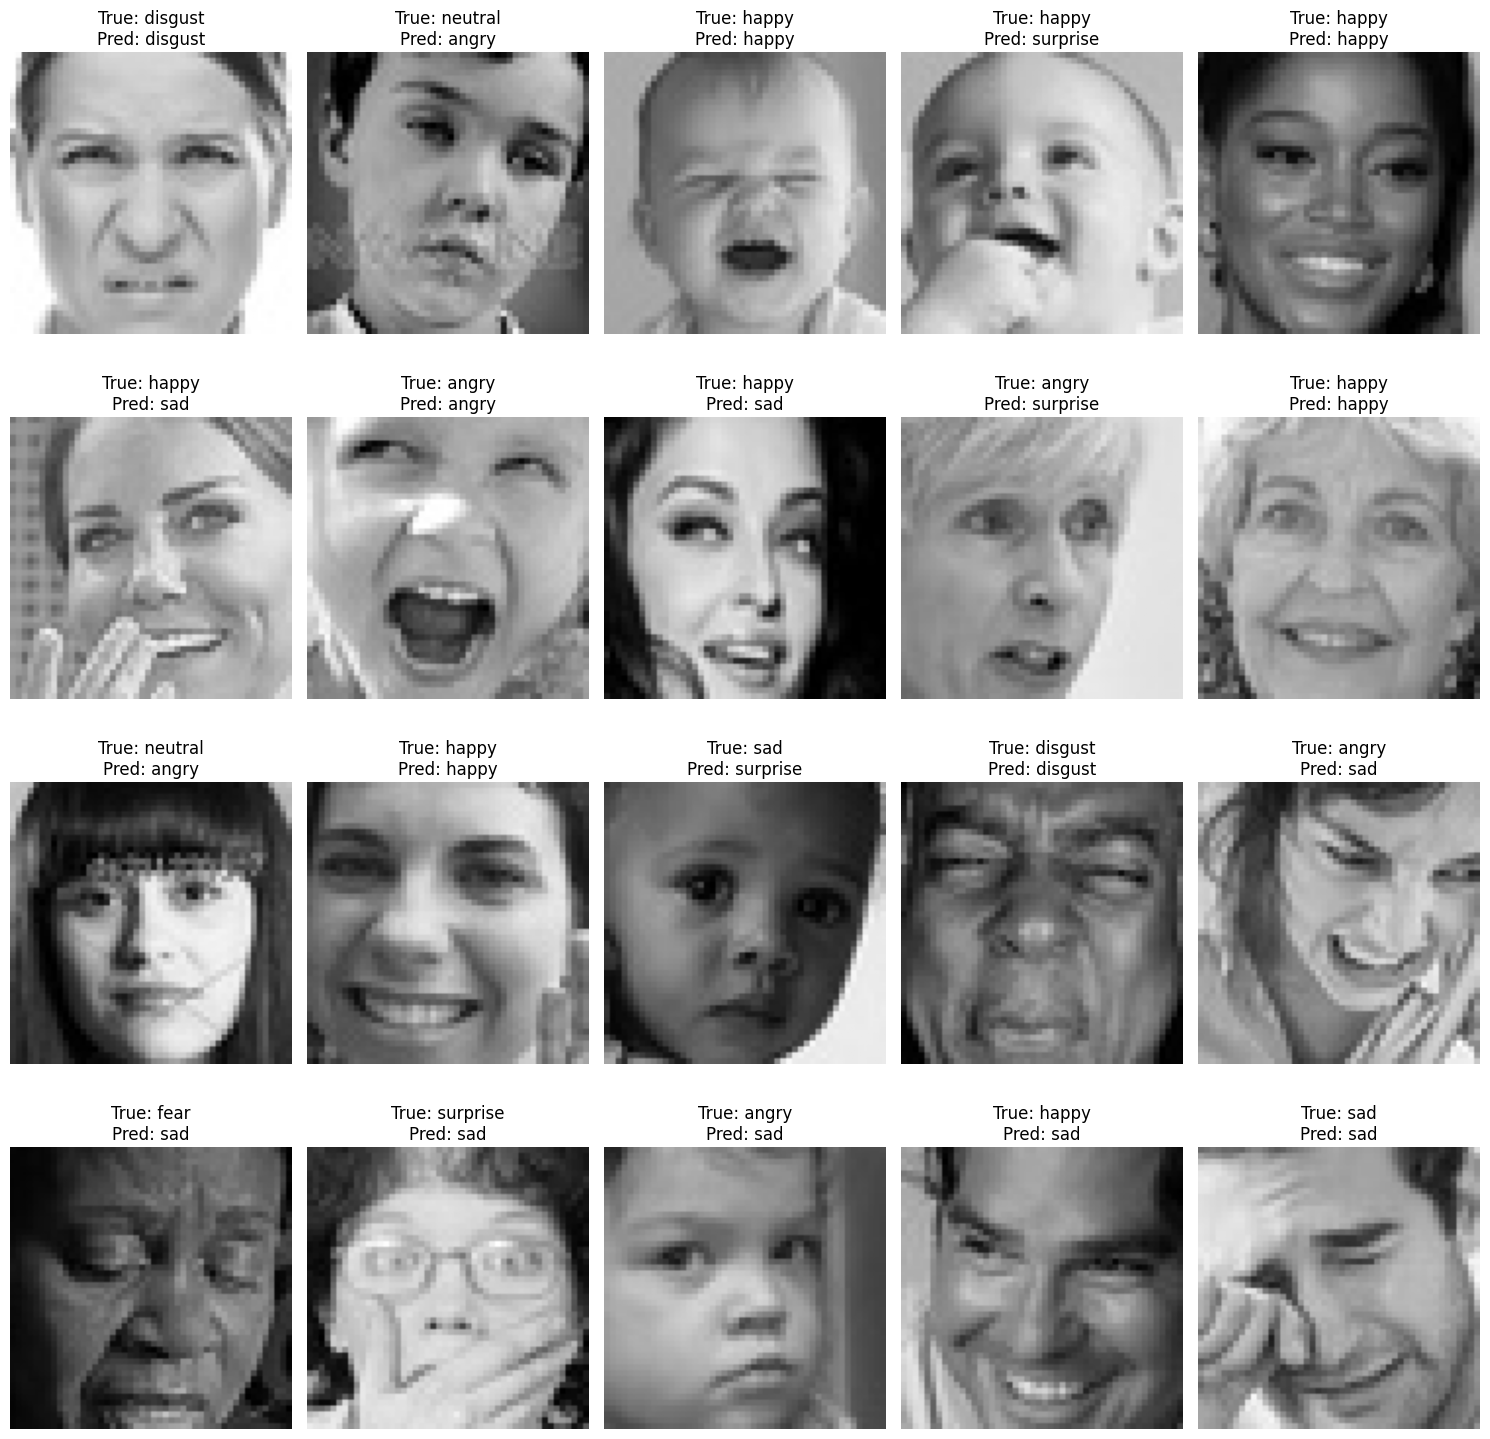

In [47]:
num_samples = 20

plt.figure(figsize=(15, 15))

for i in range(num_samples):
    # Select a random index from the test set.
    idx = random.randint(0, test_generator.samples - 1)

    # Get the image and its true label.
    # test_generator[idx] returns a batch (here, a batch of 1 image).
    x, y_true = test_generator[idx]
    image = x[0]

    # Determine the true label index and corresponding class name.
    true_label_index = np.argmax(y_true[0])

    # Predict the image's class using your model.
    prediction = model.predict(x)
    predicted_label_index = np.argmax(prediction)

    # Prepare the image for display. (Reverse preprocessing so the image looks correct.)
    display_img = deprocess_image(image)

    # Plot the image with true and predicted labels.
    plt.subplot(4, 5, i + 1)
    plt.imshow(display_img)
    plt.title(f"True: {class_names[true_label_index]}\nPred: {class_names[predicted_label_index]}")
    plt.axis("off")

plt.tight_layout()
plt.show()